In [3]:
from qutip import *
from qutip.qip.operations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#brute force the alpha beta, no lindblad evolution

# Creating arbitrary state

In [28]:
def genstate():
    #every run of this cell will generate new alpha beta
    alpha = np.random.random()
    beta = np.sqrt(1-alpha**2)
    #print('alpha =',alpha, '\nbeta =', beta, '\ncheck=', alpha**2+beta**2)
    return(alpha, beta)
#Note that this does not generate uniform(0,1) for beta.

# Making Zs operator and SWAP

In [29]:
#Zs operator
theta = 0.01
#weak_sz = np.exp(np.imag*sigmaz()*theta/2)
weak_sz = qeye(2) * np.cos(theta/2) + 1*sigmaz() * np.sin(theta/2)
Z = tensor(weak_sz, qeye(2))

#Ucnot operator
weak_sw = tensor(qeye(2),qeye(2)) * np.cos(theta) + 1* swap() * np.sin(theta)

#Hamiltonian
H = Z*weak_sw

# Measurement operators

In [30]:
e = basis(2,1)
g = basis(2,0)

proj0 = g * g.dag()
proj1 = e * e.dag()

#operators used to change state to post measurement state
m0 = tensor(qeye(2), proj0)
m1 = tensor(qeye(2), proj1)

#operators used to find prob of alpha,beta
n0 = tensor(proj0, qeye(2))
n1 = tensor(proj1, qeye(2))

# Creating post measurement state for each possible outcome and tensoring new env qubit and repeating.

In [45]:
#arr_of_arr contains every run with different initial states
arr_of_arr = []

#100 runs will generate 100 curves on the plot

for j in range(0,100):
    j = j+1
    #Generating the system and environment state
    alpha, beta = genstate()
    sys = (alpha*basis(2,0) + beta*basis(2,1)).unit()
    env = basis(2,0)
    psi = tensor(sys,g).unit()

    ########################################
    arr_e0_s0 = []
    arr_e0_s1 = []
    arr_e1_s0 = []
    arr_e1_s1 = []

    tlist = []
    psit0 = psi
    ########################################
    
    n = 200
    for i in range(0,n):
        #sets up x axis, number of env bits
        tlist = tlist + [i]
        #interact with ZUcnot
        psiH = (H*psit0).unit()
        #prob of no jump
        p0 = expect(m0,psiH)
        #prob of jump
        p1 = 1-p0
        #create RNG number r
        r = np.random.random()
        #no jump case
        if(r<p0):
            #measure env 0, new state with env 0:
            psit0 = (m0*psiH).unit()
            #measure beta
            e0_s1 = expect(n1,psit0)
            arr_e0_s1 = arr_e0_s1 + [e0_s1]
            #reinitialize the state            
            psit0 = tensor((psit0[0][0][0]*g + psit0[2][0][0]*e), g) 
            continue
        #jump case
        else:
            count = count + 1
            #measure env 1, new state w env 1:
            psit0 = (m1*psiH).unit()
            #measure beta
            e1_s1 = expect(n1,psit0)
            arr_e0_s1 = arr_e0_s1 + [e1_s1] + [0]*(n-i-1)
            break
        #reinitialize, adds new env qubit
    arr_of_arr = arr_of_arr + [arr_e0_s1]

In [43]:
for i in arr_of_arr:
    print(len(i))

200
200
200
200
200


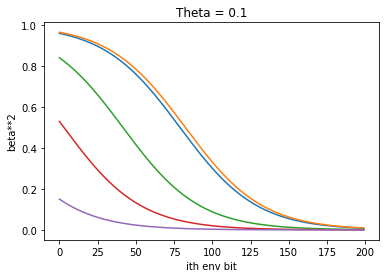

In [44]:
for i in arr_of_arr:    
    plt.plot(tlist,i)
    plt.title('Theta = 0.1')
    plt.xlabel('ith env bit')
    plt.ylabel('beta**2')
    #plt.legend(('beta', 's1'))
plt.show()

In [36]:
# need to figure out how to introduced 2nd environment qubit onwards. 
# Not sure if mesolve or mcsolve is being used correctly
# the state H*psi
#figure out pre and post measurement state. then we can tensor on the next env qubit and repeat. 
#try recursion on eqn 66
#check if measurement works by writing a simple 1/root2 0 + 1/root2 1